In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
model = pybamm.lithium_ion.DFN(options={
    "contact resistance": "true",
    "open-circuit potential": "current sigmoid",
    "thermal": "lumped",
    "SEI": "interstitial-diffusion limited",
    "SEI on cracks": "true",
    "SEI film resistance": "distributed", 
    "SEI porosity change": "true",
    "particle mechanics": "constant cracks",
    "loss of active material": "stress-driven",
    "lithium plating": "partially reversible"
})

param = pybamm.ParameterValues("OKane2023")
param.update({
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393,
    
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    #"Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    #"Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    #"Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    #'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 

    #'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.010,
    'Inner SEI lithium interstitial diffusivity [m2.s-1]':3.E-20, 
    'Dead lithium decay constant [s-1]':1.0E-13,
    'Lithium plating kinetic rate constant [m.s-1]':1E-14,
    'Negative electrode LAM constant proportional term [s-1]':1E-9,
    'Negative electrode cracking rate':1E-25,
    'Outer SEI partial molar volume [m3.mol-1]':6.41E-05,
    "SEI growth activation energy [J.mol-1]":2e4,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
})

exp = pybamm.Experiment(
    [("Rest for 60 seconds (1 second period)", "Discharge at 2C for 72 seconds or until 2.5V (0.1 second period)", 
    "Rest for 1 hour (1 second period)")] * 2,
)
exp = pybamm.Experiment(
    [(
        "Rest for 1 seconds", 
        "Discharge at 2C for 72 seconds or until 2.5V", )] * 2,
)

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 20,  # positive particle
}

sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve()

At t = 54.9526, , mxstep steps taken before reaching tout.
At t = 54.9526, , mxstep steps taken before reaching tout.
At t = 54.9527, , mxstep steps taken before reaching tout.
At t = 54.9527, , mxstep steps taken before reaching tout.
At t = 17.4527, , mxstep steps taken before reaching tout.
At t = 17.4527, , mxstep steps taken before reaching tout.
At t = 17.4527, , mxstep steps taken before reaching tout.
At t = 17.4527, , mxstep steps taken before reaching tout.
At t = 17.4527, , mxstep steps taken before reaching tout.
At t = 17.4528, , mxstep steps taken before reaching tout.
2023-07-01 22:11:42.834 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Maximum number of decreased steps occurred at t=38.500000001000004 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve

In [20]:
import matplotlib as mpl; 
font = {'family' : 'DejaVu Sans','size'   : 14}
mpl.rc('font', **font)
vars = [
    "Discharge capacity [A.h]", 
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "Terminal voltage [V]",
    "Negative electrode porosity",
    "Electrolyte concentration [mol.m-3]"
]
quick_plot = pybamm.QuickPlot(sol, vars,variable_limits='tight') #     
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [15]:
quick_plot = pybamm.QuickPlot(sol)
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [24]:

print(sol.cycles[-1]["Total capacity lost to side reactions [A.h]"].entries[-1])
print(sol.cycles[-1]["Total capacity lost to side reactions [A.h]"].entries[-1])
print(sol.cycles[0]["Loss of capacity to SEI on cracks [A.h]"].entries[0])

276.5240396132891
276.5240396132891
276.466493385867


In [7]:
t_seconds = sol["Time [s]"].entries
t_hours = (t_seconds - 60) / 3600
I = sol["Current [A]"].entries
Q = sol["Discharge capacity [A.h]"].entries
V = sol["Terminal voltage [V]"].entries

In [8]:
# import experimental GITT data from file
import os
BasicPath = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/InputData/") #
GITT_data = pd.read_csv(
    BasicPath+"GITT/2C_GITT_25deg_Niall.csv", comment="#", header=None
).to_numpy()
t_exp = GITT_data[:,0]/3600
I_exp = -GITT_data[:,3]/1000
V_exp = GITT_data[:,2]
#Q_exp = GITT_data[:,1]/1000
Q_exp = []
for i in range (len(t_exp)):
    Q_temp = np.trapz(I_exp[0:i],t_exp[0:i])
    Q_exp.append(Q_temp)


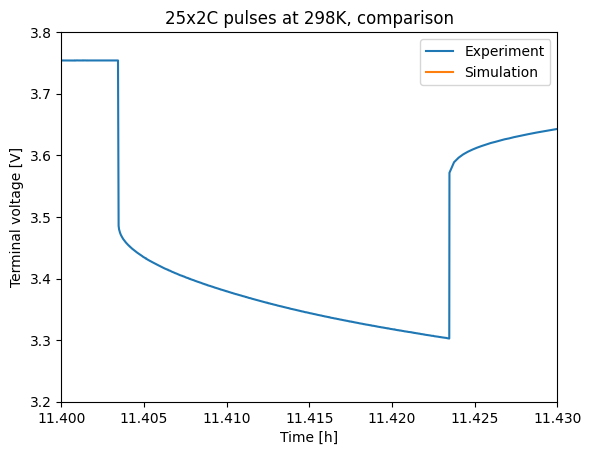

In [9]:
fig, ax = plt.subplots()
ax.plot(t_exp-t_exp[0],V_exp,label='Experiment')
ax.plot(t_hours,V,label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('25x2C pulses at 298K, comparison')
ax.legend()
plt.xlim(11.4,11.43)
plt.ylim(3.2,3.8)
#plt.savefig('/mnt/c/Users/sokane/pybamm_data/validation_data/GITT_2C_discharge_298K_zoomed.png')
plt.show()

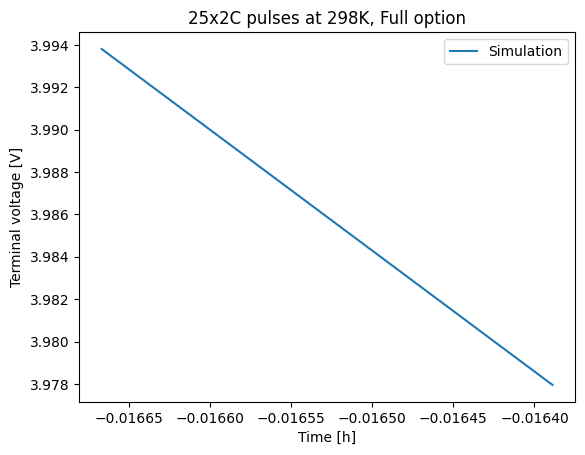

In [12]:
fig, ax = plt.subplots()
#ax.plot(t_exp-t_exp[0],V_exp,label='Experiment')
ax.plot(t_hours,V,label='Simulation')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Terminal voltage [V]')
ax.set_title('25x2C pulses at 298K, Full option')
ax.legend()
#plt.xlim(11.4,11.43)
#plt.ylim(3.2,3.8)
SavePath = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim/GITT_Validation/") #
plt.savefig(
    SavePath +  
    f"25x2C pulses at 298K, comparison - Full option.png", 
    dpi=300)